In [2]:
# VolRecon

import argparse
from re import I
from stat import UF_OPAQUE
from tqdm import tqdm
import math

import torch
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import WandbLogger
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.utilities.model_summary import ModelSummary


from code.model import VolRecon
from code.dataset.dtu_train import MVSDataset
from code.dataset.dtu_test_sparse import DtuFitSparse
from code.dataset.general_fit import GeneralFit

PI = math.pi
device = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------------- main function

seed_everything(0, workers=True)    

# -------------------------------- args for training and models ---------------------
class dummy:
    def __init__(self):
        self.a=1
args = dummy()

setattr(args, 'batch_size', 2)
setattr(args, 'extract_geometry', True)
setattr(args, 'test_general', True)
setattr(args, 'test_n_view', 5) #
setattr(args, 'test_dir', '../Rectified_colmap')
setattr(args, 'load_ckpt', 'checkpoints/epoch=15-step=193199.ckpt')
setattr(args, 'train_ray_num',1024)
setattr(args, 'lr', 0.0001)
setattr(args, 'max_epochs', 16)
setattr(args, 'val_only', False)
setattr(args, 'volume_reso', 96)
setattr(args, 'coarse_sample', 64)
setattr(args, 'fine_sample', 64)
setattr(args, 'weight_rgb', 1.0)
setattr(args, 'weight_depth', 1.0)
setattr(args, 'logdir', './checkpoints')
setattr(args, 'out_dir', './outputs_g_test') #
setattr(args, 'test_ray_num', 400)
setattr(args, 'test_sample_coarse', 64)
setattr(args, 'test_sample_fine', 64)
setattr(args, 'test_coarse_only', False)
setattr(args, 'set', 0)
setattr(args, 'n_randomly_generated_views', 1)


batch_size = args.batch_size
num_workers = 12
devices = [0]
# -------------------------------- dataset ----------------------------------------
if not args.extract_geometry:
    # training
    dtu_dataset_train = MVSDataset(            
            root_dir=args.root_dir,
            split="train",
            split_filepath="code/dataset/dtu/lists/train.txt",
            pair_filepath="code/dataset/dtu/dtu_pairs.txt",
            n_views=3,
            )

    dtu_dataset_val = MVSDataset(            
            root_dir=args.root_dir,
            split="test",
            split_filepath="code/dataset/dtu/lists/test.txt",
            pair_filepath="code/dataset/dtu/dtu_pairs.txt",
            n_views=3,
            test_ref_views = [23],  # only use view 23
            )

    print("dtu_dataset_train:", len(dtu_dataset_train))
    print("dtu_dataset_val:", len(dtu_dataset_val))

    dataloader_train = DataLoader(dtu_dataset_train,
                                    batch_size=batch_size, 
                                    num_workers=num_workers, 
                                    shuffle=True)  
    dataloader_val = DataLoader(dtu_dataset_val,
                                    batch_size=batch_size, 
                                    num_workers=num_workers, 
                                    shuffle=False)  
else:
    dataloader_test = []
    # dtu, 15 test scenes
    if not args.test_general:
        for scan in [24, 37, 40, 55, 63, 65, 69, 83, 97, 105, 106, 110, 114, 118, 122]:
            
            dataset_tmp = DtuFitSparse(root_dir=args.test_dir, 
                                split="test", 
                                scan_id='scan%d'%scan, 
                                n_views=args.test_n_view,
                                set=args.set)
            dataloader_tmp = DataLoader(dataset_tmp,
                                            batch_size=1, 
                                            num_workers=1, 
                                            shuffle=False)  
            dataloader_test.append(dataloader_tmp)
    else:
        for scan in ["scan1"]:
            
            dataset_tmp = GeneralFit(root_dir=args.test_dir, 
                                scan_id=scan, 
                                n_views=args.test_n_view,
                                n_randomly_generated_views=args.n_randomly_generated_views)
            dataloader_tmp = DataLoader(dataset_tmp,
                                            batch_size=1, 
                                            num_workers=1, 
                                            shuffle=False)  
            dataloader_test.append(dataloader_tmp)

# -------------------------------- lightning module -------------------------------
if args.load_ckpt:
    volrecon = VolRecon.load_from_checkpoint(checkpoint_path=args.load_ckpt, args=args)
    print("Model loaded:", args.load_ckpt)
    for param in volrecon.parameters():
        param.requires_grad = False
else:
    volrecon = VolRecon(args)





Global seed set to 0
Lightning automatically upgraded your loaded checkpoint from v1.5.10 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file checkpoints/epoch=15-step=193199.ckpt`


Model loaded: checkpoints/epoch=15-step=193199.ckpt


In [3]:
import numpy as np

In [4]:
item = dataset_tmp[0]
ref_img = item['ref_img']
source_imgs = item['source_imgs']
meta = item['meta']

In [5]:
ref_img.shape

torch.Size([3, 600, 800])

In [6]:
source_imgs.size()

torch.Size([5, 3, 600, 800])

In [7]:
np.linalg.norm(ref_img-source_imgs[0].numpy(force=True))

0.0

This shows that the first source image is the same as the reference image, in the following we see how much the quality is affected when we change this. <br>
First we generate a random view with the current code

In [8]:
# -------------------------------- trainer ---------------------------------------
trainer = pl.Trainer(
    accelerator="gpu" if device=="cuda" else "cpu", 
    #devices=2,
    #strategy = "ddp_notebook",
    max_epochs=args.max_epochs,
    check_val_every_n_epoch=1, 
    num_sanity_val_steps=0,
    )


ModelSummary(volrecon, max_depth=1)

# -------------------------------- train or/and testing --------------------------------
if not args.extract_geometry:
    if args.val_only:
        print("[only validation]")
        trainer.validate(volrecon, dataloader_train)
    else:
        print("[start training]")
        trainer.fit(volrecon, dataloader_train, dataloader_val)
else:
    for dataloader_test1 in tqdm(dataloader_test):
        trainer.validate(volrecon, dataloader_test1)

print("end")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


  0%|          | 0/1 [00:00<?, ?it/s]You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/rozenberszki/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

start extracting geometry


/home/rozenberszki/.local/lib/python3.8/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


1 1
2 2
3 3
4 4
5 5


6 6
7 7
8 8
9 9
10 10


11 11
12 12
13 13
14 14
15 15


16 16
17 17
18 18
19 19
20 20


21 21
22 22
23 23
24 24
25 25


26 26
27 27
28 28
29 29
30 30


31 31
32 32
33 33
34 34
35 35


36 36
37 37
38 38
39 39
40 40


41 41
42 42
43 43
44 44
45 45


46 46
47 47
48 48
49 49
50 50


51 51
52 52
53 53
54 54
55 55


56 56
57 57
58 58
59 59
60 60


61 61
62 62
63 63
64 64
65 65


66 66
67 67
68 68
69 69
70 70


71 71
72 72
73 73
74 74
75 75


76 76
77 77
78 78
79 79
80 80


81 81
82 82
83 83
84 84
85 85


86 86
87 87
88 88
89 89
90 90


91 91
92 92
93 93
94 94
95 95


96 96
97 97
98 98
99 99
100 100


101 101
102 102
103 103
104 104
105 105


106 106
107 107
108 108
109 109
110 110


111 111
112 112
113 113
114 114
115 115


116 116
117 117
118 118
119 119
120 120


121 121
122 122
123 123
124 124
125 125


126 126
127 127
128 128
129 129
130 130


131 131
132 132
133 133
134 134
135 135


136 136
137 137
138 138
139 139
140 140


141 141
142 142
143 143
144 144
145 145


146 146
147 147
148 148
149 149
150 150


151 151
152 152
153 153
154 154
155 155


156 156
157 157
158 158
159 159
160 160


161 161
162 162
163 163
164 164
165 165


166 166
167 167
168 168
169 169
170 170


171 171
172 172
173 173
174 174
175 175


176 176
177 177
178 178
179 179
180 180


181 181
182 182
183 183
184 184
185 185


186 186
187 187
188 188
189 189
190 190


191 191
192 192
193 193
194 194
195 195


196 196
197 197
198 198
199 199
200 200


201 201
202 202
203 203
204 204
205 205


206 206
207 207
208 208
209 209
210 210


211 211
212 212
213 213
214 214
215 215


216 216
217 217
218 218
219 219
220 220


221 221
222 222
223 223
224 224
225 225


226 226
227 227
228 228
229 229
230 230


231 231
232 232
233 233
234 234
235 235


236 236
237 237
238 238
239 239
240 240


241 241
242 242
243 243
244 244
245 245


246 246
247 247
248 248
249 249
250 250


251 251
252 252
253 253
254 254
255 255


256 256
257 257
258 258
259 259
260 260


261 261
262 262
263 263
264 264
265 265


266 266
267 267
268 268
269 269
270 270


271 271
272 272
273 273
274 274
275 275


276 276
277 277
278 278
279 279
280 280


281 281
282 282
283 283
284 284
285 285


286 286
287 287
288 288
289 289
290 290


291 291
292 292
293 293
294 294
295 295


296 296
297 297
298 298
299 299
300 300


301 301
302 302
303 303
304 304
305 305


306 306
307 307
308 308
309 309
310 310


311 311
312 312
313 313
314 314
315 315


316 316
317 317
318 318
319 319
320 320


321 321
322 322
323 323
324 324
325 325


326 326
327 327
328 328
329 329
330 330


331 331
332 332
333 333
334 334
335 335


336 336
337 337
338 338
339 339
340 340


341 341
342 342
343 343
344 344
345 345


346 346
347 347
348 348
349 349
350 350


351 351
352 352
353 353
354 354
355 355


356 356
357 357
358 358
359 359
360 360


361 361
362 362
363 363
364 364
365 365


366 366
367 367
368 368
369 369
370 370


371 371
372 372
373 373
374 374
375 375


376 376
377 377
378 378
379 379
380 380


381 381
382 382
383 383
384 384
385 385


386 386
387 387
388 388
389 389
390 390


391 391
392 392
393 393
394 394
395 395


396 396
397 397
398 398
399 399
400 400


401 401
402 402
403 403
404 404
405 405


406 406
407 407
408 408
409 409
410 410


411 411
412 412
413 413
414 414
415 415


416 416
417 417
418 418
419 419
420 420


421 421
422 422
423 423
424 424
425 425


426 426
427 427
428 428
429 429
430 430


431 431
432 432
433 433
434 434
435 435


436 436
437 437
438 438
439 439
440 440


441 441
442 442
443 443
444 444
445 445


446 446
447 447
448 448
449 449
450 450


451 451
452 452
453 453
454 454
455 455


456 456
457 457
458 458
459 459
460 460


461 461
462 462
463 463
464 464
465 465


466 466
467 467
468 468
469 469
470 470


471 471
472 472
473 473
474 474
475 475


476 476
477 477
478 478
479 479
480 480


481 481
482 482
483 483
484 484
485 485


486 486
487 487
488 488
489 489
490 490


491 491
492 492
493 493
494 494
495 495


496 496
497 497
498 498
499 499
500 500


501 501
502 502
503 503
504 504
505 505


506 506
507 507
508 508
509 509
510 510


511 511
512 512
513 513
514 514
515 515


516 516
517 517
518 518
519 519
520 520


521 521
522 522
523 523
524 524
525 525


526 526
527 527
528 528
529 529
530 530


531 531
532 532
533 533
534 534
535 535


536 536
537 537
538 538
539 539
540 540


541 541
542 542
543 543
544 544
545 545


546 546
547 547
548 548
549 549
550 550


551 551
552 552
553 553
554 554
555 555


556 556
557 557
558 558
559 559
560 560


561 561
562 562
563 563
564 564
565 565


566 566
567 567
568 568
569 569
570 570


571 571
572 572
573 573
574 574
575 575


576 576
577 577
578 578
579 579
580 580


581 581
582 582
583 583
584 584
585 585


586 586
587 587
588 588
589 589
590 590


591 591
592 592
593 593
594 594
595 595


596 596
597 597
598 598
599 599
600 600


601 601
602 602
603 603
604 604
605 605


606 606
607 607
608 608
609 609
610 610


611 611
612 612
613 613
614 614
615 615


616 616
617 617
618 618
619 619
620 620


621 621
622 622
623 623
624 624
625 625


626 626
627 627
628 628
629 629
630 630


631 631
632 632
633 633
634 634
635 635


636 636
637 637
638 638
639 639
640 640


641 641
642 642
643 643
644 644
645 645


646 646
647 647
648 648
649 649
650 650


651 651
652 652
653 653
654 654
655 655


656 656
657 657
658 658
659 659
660 660


661 661
662 662
663 663
664 664
665 665


666 666
667 667
668 668
669 669
670 670


671 671
672 672
673 673
674 674
675 675


676 676
677 677
678 678
679 679
680 680


681 681
682 682
683 683
684 684
685 685


686 686
687 687
688 688
689 689
690 690


691 691
692 692
693 693
694 694
695 695


696 696
697 697
698 698
699 699
700 700


701 701
702 702
703 703
704 704
705 705


706 706
707 707
708 708
709 709
710 710


711 711
712 712
713 713
714 714
715 715


716 716
717 717
718 718
719 719
720 720


721 721
722 722
723 723
724 724
725 725


726 726
727 727
728 728
729 729
730 730


731 731
732 732
733 733
734 734
735 735


736 736
737 737
738 738
739 739
740 740


741 741
742 742
743 743
744 744
745 745


746 746
747 747
748 748
749 749
750 750


751 751
752 752
753 753
754 754
755 755


756 756
757 757
758 758
759 759
760 760


761 761
762 762
763 763
764 764
765 765


766 766
767 767
768 768
769 769
770 770


771 771
772 772
773 773
774 774
775 775


776 776
777 777
778 778
779 779
780 780


781 781
782 782
783 783
784 784
785 785


786 786
787 787
788 788
789 789
790 790


791 791
792 792
793 793
794 794
795 795


796 796
797 797
798 798
799 799
800 800


801 801
802 802
803 803
804 804
805 805


806 806
807 807
808 808
809 809
810 810


811 811
812 812
813 813
814 814
815 815


816 816
817 817
818 818
819 819
820 820


821 821
822 822
823 823
824 824
825 825


826 826
827 827
828 828
829 829
830 830


831 831
832 832
833 833
834 834
835 835


836 836
837 837
838 838
839 839
840 840


841 841
842 842
843 843
844 844
845 845


846 846
847 847
848 848
849 849
850 850


851 851
852 852
853 853
854 854
855 855


856 856
857 857
858 858
859 859
860 860


861 861
862 862
863 863
864 864
865 865


866 866
867 867
868 868
869 869
870 870


871 871
872 872
873 873
874 874
875 875


876 876
877 877
878 878
879 879
880 880


881 881
882 882
883 883
884 884
885 885


886 886
887 887
888 888
889 889
890 890


891 891
892 892
893 893
894 894
895 895


896 896
897 897
898 898
899 899
900 900


901 901
902 902
903 903
904 904
905 905


906 906
907 907
908 908
909 909
910 910


911 911
912 912
913 913
914 914
915 915


916 916
917 917
918 918
919 919
920 920


921 921
922 922
923 923
924 924
925 925


926 926
927 927
928 928
929 929
930 930


931 931
932 932
933 933
934 934
935 935


936 936
937 937
938 938
939 939
940 940


941 941
942 942
943 943
944 944
945 945


946 946
947 947
948 948
949 949
950 950


951 951
952 952
953 953
954 954
955 955


956 956
957 957
958 958
959 959
960 960


961 961
962 962
963 963
964 964
965 965


966 966
967 967
968 968
969 969
970 970


971 971
972 972
973 973
974 974
975 975


976 976
977 977
978 978
979 979
980 980


981 981
982 982
983 983
984 984
985 985


986 986
987 987
988 988
989 989
990 990


991 991
992 992
993 993
994 994
995 995


996 996
997 997
998 998
999 999
1000 1000


1001 1001
1002 1002
1003 1003
1004 1004
1005 1005


1006 1006
1007 1007
1008 1008
1009 1009
1010 1010


1011 1011
1012 1012
1013 1013
1014 1014
1015 1015


1016 1016
1017 1017
1018 1018
1019 1019
1020 1020


1021 1021
1022 1022
1023 1023
1024 1024
1025 1025


1026 1026
1027 1027
1028 1028
1029 1029
1030 1030


1031 1031
1032 1032
1033 1033
1034 1034
1035 1035


1036 1036
1037 1037
1038 1038
1039 1039
1040 1040


1041 1041
1042 1042
1043 1043
1044 1044
1045 1045


1046 1046
1047 1047
1048 1048
1049 1049
1050 1050


1051 1051
1052 1052
1053 1053
1054 1054
1055 1055


1056 1056
1057 1057
1058 1058
1059 1059
1060 1060


1061 1061
1062 1062
1063 1063
1064 1064
1065 1065


1066 1066
1067 1067
1068 1068
1069 1069
1070 1070


1071 1071
1072 1072
1073 1073
1074 1074
1075 1075


1076 1076
1077 1077
1078 1078
1079 1079
1080 1080


1081 1081
1082 1082
1083 1083
1084 1084
1085 1085


1086 1086
1087 1087
1088 1088
1089 1089
1090 1090


1091 1091
1092 1092
1093 1093
1094 1094
1095 1095


1096 1096
1097 1097
1098 1098
1099 1099
1100 1100


1101 1101
1102 1102
1103 1103
1104 1104
1105 1105


1106 1106
1107 1107
1108 1108
1109 1109
1110 1110


1111 1111
1112 1112
1113 1113
1114 1114
1115 1115


1116 1116
1117 1117
1118 1118
1119 1119
1120 1120


1121 1121
1122 1122
1123 1123
1124 1124
1125 1125


1126 1126
1127 1127
1128 1128
1129 1129
1130 1130


1131 1131
1132 1132
1133 1133
1134 1134
1135 1135


1136 1136
1137 1137
1138 1138
1139 1139
1140 1140


1141 1141
1142 1142
1143 1143
1144 1144
1145 1145


1146 1146
1147 1147
1148 1148
1149 1149
1150 1150


1151 1151
1152 1152
1153 1153
1154 1154
1155 1155


1156 1156
1157 1157
1158 1158
1159 1159
1160 1160


1161 1161
1162 1162
1163 1163
1164 1164
1165 1165


1166 1166
1167 1167
1168 1168
1169 1169
1170 1170


1171 1171
1172 1172
1173 1173
1174 1174
1175 1175


1176 1176
1177 1177
1178 1178
1179 1179
1180 1180


1181 1181
1182 1182
1183 1183
1184 1184
1185 1185


1186 1186
1187 1187
1188 1188
1189 1189
1190 1190


1191 1191
1192 1192
1193 1193
1194 1194
1195 1195


100%|██████████| 1200/1200 [00:55<00:00, 21.62it/s]

1196 1196
1197 1197
1198 1198
1199 1199
1200 1200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        psnr/coarse        │            0.0            │
│         psnr/fine         │            0.0            │
│   val/loss_depth_coarse   │            0.0            │
│    val/loss_depth_fine    │            0.0            │
│      val/rgb_coarse       │            0.0            │
│       val/rgb_fine        │            0.0            │
└───────────────────────────┴───────────────────────────┘

100%|██████████| 1/1 [00:59<00:00, 59.04s/it]

end


The algorithm generated view number 29. We will generate the same view, while discarding it from source images. <br>
We will make changes in general_fit.py and restart the kernel to get those changes. <br>
We perform the following changes: <br>

1. In general_fit.py insert in line 91: 
<pre><code>       if self.n_randomly_generated_views > 0 :
            return [metas[29]] </code></pre> (here if the first run generated another index than 29, you should use that index)
2. In general_fit.py replace line 233 with  `src_idx = idx[1:] + [self.n_views]` 
3. In general_fit.py replace 230 line with `view_ids = [ref_view] + src_views`
4. In the following code (args), set out_dir to './outputs_g_test2'
5. Restat the kernel so that python loads the new version of general_fit.py




In [1]:
# VolRecon

import argparse
from re import I
from stat import UF_OPAQUE
from tqdm import tqdm
import math

import torch
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import WandbLogger
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.utilities.model_summary import ModelSummary


from code.model import VolRecon
from code.dataset.dtu_train import MVSDataset
from code.dataset.dtu_test_sparse import DtuFitSparse
from code.dataset.general_fit import GeneralFit

PI = math.pi
device = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------------- main function

seed_everything(0, workers=True)    

# -------------------------------- args for training and models ---------------------
class dummy:
    def __init__(self):
        self.a=1
args = dummy()

setattr(args, 'batch_size', 2)
setattr(args, 'extract_geometry', True)
setattr(args, 'test_general', True)
setattr(args, 'test_n_view', 5) #
setattr(args, 'test_dir', '../Rectified_colmap')
setattr(args, 'load_ckpt', 'checkpoints/epoch=15-step=193199.ckpt')
setattr(args, 'train_ray_num',1024)
setattr(args, 'lr', 0.0001)
setattr(args, 'max_epochs', 16)
setattr(args, 'val_only', False)
setattr(args, 'volume_reso', 96)
setattr(args, 'coarse_sample', 64)
setattr(args, 'fine_sample', 64)
setattr(args, 'weight_rgb', 1.0)
setattr(args, 'weight_depth', 1.0)
setattr(args, 'logdir', './checkpoints')
setattr(args, 'out_dir', './outputs_g_test2') #
setattr(args, 'test_ray_num', 400)
setattr(args, 'test_sample_coarse', 64)
setattr(args, 'test_sample_fine', 64)
setattr(args, 'test_coarse_only', False)
setattr(args, 'set', 0)
setattr(args, 'n_randomly_generated_views', 1)


batch_size = args.batch_size
num_workers = 12
devices = [0]
# -------------------------------- dataset ----------------------------------------
if not args.extract_geometry:
    # training
    dtu_dataset_train = MVSDataset(            
            root_dir=args.root_dir,
            split="train",
            split_filepath="code/dataset/dtu/lists/train.txt",
            pair_filepath="code/dataset/dtu/dtu_pairs.txt",
            n_views=3,
            )

    dtu_dataset_val = MVSDataset(            
            root_dir=args.root_dir,
            split="test",
            split_filepath="code/dataset/dtu/lists/test.txt",
            pair_filepath="code/dataset/dtu/dtu_pairs.txt",
            n_views=3,
            test_ref_views = [23],  # only use view 23
            )

    print("dtu_dataset_train:", len(dtu_dataset_train))
    print("dtu_dataset_val:", len(dtu_dataset_val))

    dataloader_train = DataLoader(dtu_dataset_train,
                                    batch_size=batch_size, 
                                    num_workers=num_workers, 
                                    shuffle=True)  
    dataloader_val = DataLoader(dtu_dataset_val,
                                    batch_size=batch_size, 
                                    num_workers=num_workers, 
                                    shuffle=False)  
else:
    dataloader_test = []
    # dtu, 15 test scenes
    if not args.test_general:
        for scan in [24, 37, 40, 55, 63, 65, 69, 83, 97, 105, 106, 110, 114, 118, 122]:
            
            dataset_tmp = DtuFitSparse(root_dir=args.test_dir, 
                                split="test", 
                                scan_id='scan%d'%scan, 
                                n_views=args.test_n_view,
                                set=args.set)
            dataloader_tmp = DataLoader(dataset_tmp,
                                            batch_size=1, 
                                            num_workers=1, 
                                            shuffle=False)  
            dataloader_test.append(dataloader_tmp)
    else:
        for scan in ["scan1"]:
            
            dataset_tmp = GeneralFit(root_dir=args.test_dir, 
                                scan_id=scan, 
                                n_views=args.test_n_view,
                                n_randomly_generated_views=args.n_randomly_generated_views)
            dataloader_tmp = DataLoader(dataset_tmp,
                                            batch_size=1, 
                                            num_workers=1, 
                                            shuffle=False)  
            dataloader_test.append(dataloader_tmp)

# -------------------------------- lightning module -------------------------------
if args.load_ckpt:
    volrecon = VolRecon.load_from_checkpoint(checkpoint_path=args.load_ckpt, args=args)
    print("Model loaded:", args.load_ckpt)
    for param in volrecon.parameters():
        param.requires_grad = False
else:
    volrecon = VolRecon(args)





Global seed set to 0
Lightning automatically upgraded your loaded checkpoint from v1.5.10 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file checkpoints/epoch=15-step=193199.ckpt`


Model loaded: checkpoints/epoch=15-step=193199.ckpt


In [2]:
# -------------------------------- trainer ---------------------------------------
trainer = pl.Trainer(
    accelerator="gpu" if device=="cuda" else "cpu", 
    #devices=2,
    #strategy = "ddp_notebook",
    max_epochs=args.max_epochs,
    check_val_every_n_epoch=1, 
    num_sanity_val_steps=0,
    )


ModelSummary(volrecon, max_depth=1)

# -------------------------------- train or/and testing --------------------------------
if not args.extract_geometry:
    if args.val_only:
        print("[only validation]")
        trainer.validate(volrecon, dataloader_train)
    else:
        print("[start training]")
        trainer.fit(volrecon, dataloader_train, dataloader_val)
else:
    for dataloader_test1 in tqdm(dataloader_test):
        trainer.validate(volrecon, dataloader_test1)

print("end")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
  0%|          | 0/1 [00:00<?, ?it/s]You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/rozenberszki/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

start extracting geometry


/home/rozenberszki/.local/lib/python3.8/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


1 1
2 2
3 3
4 4
5 5


6 6
7 7
8 8
9 9
10 10


11 11
12 12
13 13
14 14
15 15


16 16
17 17
18 18
19 19
20 20


21 21
22 22
23 23
24 24
25 25


26 26
27 27
28 28
29 29
30 30


31 31
32 32
33 33
34 34
35 35


36 36
37 37
38 38
39 39
40 40


41 41
42 42
43 43
44 44
45 45


46 46
47 47
48 48
49 49
50 50


51 51
52 52
53 53
54 54
55 55


56 56
57 57
58 58
59 59
60 60


61 61
62 62
63 63
64 64
65 65


66 66
67 67
68 68
69 69
70 70


71 71
72 72
73 73
74 74
75 75


76 76
77 77
78 78
79 79
80 80


81 81
82 82
83 83
84 84
85 85


86 86
87 87
88 88
89 89
90 90


91 91
92 92
93 93
94 94
95 95


96 96
97 97
98 98
99 99
100 100


101 101
102 102
103 103
104 104
105 105


106 106
107 107
108 108
109 109
110 110


111 111
112 112
113 113
114 114
115 115


116 116
117 117
118 118
119 119
120 120


121 121
122 122
123 123
124 124
125 125


126 126
127 127
128 128
129 129
130 130


131 131
132 132
133 133
134 134
135 135


136 136
137 137
138 138
139 139
140 140


141 141
142 142
143 143
144 144
145 145


146 146
147 147
148 148
149 149
150 150


151 151
152 152
153 153
154 154
155 155


156 156
157 157
158 158
159 159
160 160


161 161
162 162
163 163
164 164
165 165


166 166
167 167
168 168
169 169
170 170


171 171
172 172
173 173
174 174
175 175


176 176
177 177
178 178
179 179
180 180


181 181
182 182
183 183
184 184
185 185


186 186
187 187
188 188
189 189
190 190


191 191
192 192
193 193
194 194
195 195


196 196
197 197
198 198
199 199
200 200


201 201
202 202
203 203
204 204
205 205


206 206
207 207
208 208
209 209
210 210


211 211
212 212
213 213
214 214
215 215


216 216
217 217
218 218
219 219
220 220


221 221
222 222
223 223
224 224
225 225


226 226
227 227
228 228
229 229
230 230


231 231
232 232
233 233
234 234
235 235


236 236
237 237
238 238
239 239
240 240


241 241
242 242
243 243
244 244
245 245


246 246
247 247
248 248
249 249
250 250


251 251
252 252
253 253
254 254
255 255


256 256
257 257
258 258
259 259
260 260


261 261
262 262
263 263
264 264
265 265


266 266
267 267
268 268
269 269
270 270


271 271
272 272
273 273
274 274
275 275


276 276
277 277
278 278
279 279
280 280


281 281
282 282
283 283
284 284
285 285


286 286
287 287
288 288
289 289
290 290


291 291
292 292
293 293
294 294
295 295


296 296
297 297
298 298
299 299
300 300


301 301
302 302
303 303
304 304
305 305


306 306
307 307
308 308
309 309
310 310


311 311
312 312
313 313
314 314
315 315


316 316
317 317
318 318
319 319
320 320


321 321
322 322
323 323
324 324
325 325


326 326
327 327
328 328
329 329
330 330


331 331
332 332
333 333
334 334
335 335


336 336
337 337
338 338
339 339
340 340


341 341
342 342
343 343
344 344
345 345


346 346
347 347
348 348
349 349
350 350


351 351
352 352
353 353
354 354
355 355


356 356
357 357
358 358
359 359
360 360


361 361
362 362
363 363
364 364
365 365


366 366
367 367
368 368
369 369
370 370


371 371
372 372
373 373
374 374
375 375


376 376
377 377
378 378
379 379
380 380


381 381
382 382
383 383
384 384
385 385


386 386
387 387
388 388
389 389
390 390


391 391
392 392
393 393
394 394
395 395


396 396
397 397
398 398
399 399
400 400


401 401
402 402
403 403
404 404
405 405


406 406
407 407
408 408
409 409
410 410


411 411
412 412
413 413
414 414
415 415


416 416
417 417
418 418
419 419
420 420


421 421
422 422
423 423
424 424
425 425


426 426
427 427
428 428
429 429
430 430


431 431
432 432
433 433
434 434
435 435


436 436
437 437
438 438
439 439
440 440


441 441
442 442
443 443
444 444
445 445


446 446
447 447
448 448
449 449
450 450


451 451
452 452
453 453
454 454
455 455


456 456
457 457
458 458
459 459
460 460


461 461
462 462
463 463
464 464
465 465


466 466
467 467
468 468
469 469
470 470


471 471
472 472
473 473
474 474
475 475


476 476
477 477
478 478
479 479
480 480


481 481
482 482
483 483
484 484
485 485


486 486
487 487
488 488
489 489
490 490


491 491
492 492
493 493
494 494
495 495


496 496
497 497
498 498
499 499
500 500


501 501
502 502
503 503
504 504
505 505


506 506
507 507
508 508
509 509
510 510


511 511
512 512
513 513
514 514
515 515


516 516
517 517
518 518
519 519
520 520


521 521
522 522
523 523
524 524
525 525


526 526
527 527
528 528
529 529
530 530


531 531
532 532
533 533
534 534
535 535


536 536
537 537
538 538
539 539
540 540


541 541
542 542
543 543
544 544
545 545


546 546
547 547
548 548
549 549
550 550


551 551
552 552
553 553
554 554
555 555


556 556
557 557
558 558
559 559
560 560


561 561
562 562
563 563
564 564
565 565


566 566
567 567
568 568
569 569
570 570


571 571
572 572
573 573
574 574
575 575


576 576
577 577
578 578
579 579
580 580


581 581
582 582
583 583
584 584
585 585


586 586
587 587
588 588
589 589
590 590


591 591
592 592
593 593
594 594
595 595


596 596
597 597
598 598
599 599
600 600


601 601
602 602
603 603
604 604
605 605


606 606
607 607
608 608
609 609
610 610


611 611
612 612
613 613
614 614
615 615


616 616
617 617
618 618
619 619
620 620


621 621
622 622
623 623
624 624
625 625


626 626
627 627
628 628
629 629
630 630


631 631
632 632
633 633
634 634
635 635


636 636
637 637
638 638
639 639
640 640


641 641
642 642
643 643
644 644
645 645


646 646
647 647
648 648
649 649
650 650


651 651
652 652
653 653
654 654
655 655


656 656
657 657
658 658
659 659
660 660


661 661
662 662
663 663
664 664
665 665


666 666
667 667
668 668
669 669
670 670


671 671
672 672
673 673
674 674
675 675


676 676
677 677
678 678
679 679
680 680


681 681
682 682
683 683
684 684
685 685


686 686
687 687
688 688
689 689
690 690


691 691
692 692
693 693
694 694
695 695


696 696
697 697
698 698
699 699
700 700


701 701
702 702
703 703
704 704
705 705


706 706
707 707
708 708
709 709
710 710


711 711
712 712
713 713
714 714
715 715


716 716
717 717
718 718
719 719
720 720


721 721
722 722
723 723
724 724
725 725


726 726
727 727
728 728
729 729
730 730


731 731
732 732
733 733
734 734
735 735


736 736
737 737
738 738
739 739
740 740


741 741
742 742
743 743
744 744
745 745


746 746
747 747
748 748
749 749
750 750


751 751
752 752
753 753
754 754
755 755


756 756
757 757
758 758
759 759
760 760


761 761
762 762
763 763
764 764
765 765


766 766
767 767
768 768
769 769
770 770


771 771
772 772
773 773
774 774
775 775


776 776
777 777
778 778
779 779
780 780


781 781
782 782
783 783
784 784
785 785


786 786
787 787
788 788
789 789
790 790


791 791
792 792
793 793
794 794
795 795


796 796
797 797
798 798
799 799
800 800


801 801
802 802
803 803
804 804
805 805


806 806
807 807
808 808
809 809
810 810


811 811
812 812
813 813
814 814
815 815


816 816
817 817
818 818
819 819
820 820


821 821
822 822
823 823
824 824
825 825


826 826
827 827
828 828
829 829
830 830


831 831
832 832
833 833
834 834
835 835


836 836
837 837
838 838
839 839
840 840


841 841
842 842
843 843
844 844
845 845


846 846
847 847
848 848
849 849
850 850


851 851
852 852
853 853
854 854
855 855


856 856
857 857
858 858
859 859
860 860


861 861
862 862
863 863
864 864
865 865


866 866
867 867
868 868
869 869
870 870


871 871
872 872
873 873
874 874
875 875


876 876
877 877
878 878
879 879
880 880


881 881
882 882
883 883
884 884
885 885


886 886
887 887
888 888
889 889
890 890


891 891
892 892
893 893
894 894
895 895


896 896
897 897
898 898
899 899
900 900


901 901
902 902
903 903
904 904
905 905


906 906
907 907
908 908
909 909
910 910


911 911
912 912
913 913
914 914
915 915


916 916
917 917
918 918
919 919
920 920


921 921
922 922
923 923
924 924
925 925


926 926
927 927
928 928
929 929
930 930


931 931
932 932
933 933
934 934
935 935


936 936
937 937
938 938
939 939
940 940


941 941
942 942
943 943
944 944
945 945


946 946
947 947
948 948
949 949
950 950


951 951
952 952
953 953
954 954
955 955


956 956
957 957
958 958
959 959
960 960


961 961
962 962
963 963
964 964
965 965


966 966
967 967
968 968
969 969
970 970


971 971
972 972
973 973
974 974
975 975


976 976
977 977
978 978
979 979
980 980


981 981
982 982
983 983
984 984
985 985


986 986
987 987
988 988
989 989
990 990


991 991
992 992
993 993
994 994
995 995


996 996
997 997
998 998
999 999
1000 1000


1001 1001
1002 1002
1003 1003
1004 1004
1005 1005


1006 1006
1007 1007
1008 1008
1009 1009
1010 1010


1011 1011
1012 1012
1013 1013
1014 1014
1015 1015


1016 1016
1017 1017
1018 1018
1019 1019
1020 1020


1021 1021
1022 1022
1023 1023
1024 1024
1025 1025


1026 1026
1027 1027
1028 1028
1029 1029
1030 1030


1031 1031
1032 1032
1033 1033
1034 1034
1035 1035


1036 1036
1037 1037
1038 1038
1039 1039
1040 1040


1041 1041
1042 1042
1043 1043
1044 1044
1045 1045


1046 1046
1047 1047
1048 1048
1049 1049
1050 1050


1051 1051
1052 1052
1053 1053
1054 1054
1055 1055


1056 1056
1057 1057
1058 1058
1059 1059
1060 1060


1061 1061
1062 1062
1063 1063
1064 1064
1065 1065


1066 1066
1067 1067
1068 1068
1069 1069
1070 1070


1071 1071
1072 1072
1073 1073
1074 1074
1075 1075


1076 1076
1077 1077
1078 1078
1079 1079
1080 1080


1081 1081
1082 1082
1083 1083
1084 1084
1085 1085


1086 1086
1087 1087
1088 1088
1089 1089
1090 1090


1091 1091
1092 1092
1093 1093
1094 1094
1095 1095


1096 1096
1097 1097
1098 1098
1099 1099
1100 1100


1101 1101
1102 1102
1103 1103
1104 1104
1105 1105


1106 1106
1107 1107
1108 1108
1109 1109
1110 1110


1111 1111
1112 1112
1113 1113
1114 1114
1115 1115


1116 1116
1117 1117
1118 1118
1119 1119
1120 1120


1121 1121
1122 1122
1123 1123
1124 1124
1125 1125


1126 1126
1127 1127
1128 1128
1129 1129
1130 1130


1131 1131
1132 1132
1133 1133
1134 1134
1135 1135


1136 1136
1137 1137
1138 1138
1139 1139
1140 1140


1141 1141
1142 1142
1143 1143
1144 1144
1145 1145


1146 1146
1147 1147
1148 1148
1149 1149
1150 1150


1151 1151
1152 1152
1153 1153
1154 1154
1155 1155


1156 1156
1157 1157
1158 1158
1159 1159
1160 1160


1161 1161
1162 1162
1163 1163
1164 1164
1165 1165


1166 1166
1167 1167
1168 1168
1169 1169
1170 1170


1171 1171
1172 1172
1173 1173
1174 1174
1175 1175


1176 1176
1177 1177
1178 1178
1179 1179
1180 1180


1181 1181
1182 1182
1183 1183
1184 1184
1185 1185


1186 1186
1187 1187
1188 1188
1189 1189
1190 1190


1191 1191
1192 1192
1193 1193
1194 1194
1195 1195


100%|██████████| 1200/1200 [00:55<00:00, 21.68it/s]

1196 1196
1197 1197
1198 1198
1199 1199
1200 1200


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        psnr/coarse        │            0.0            │
│         psnr/fine         │            0.0            │
│   val/loss_depth_coarse   │            0.0            │
│    val/loss_depth_fine    │            0.0            │
│      val/rgb_coarse       │            0.0            │
│       val/rgb_fine        │            0.0            │
└───────────────────────────┴───────────────────────────┘

100%|██████████| 1/1 [00:59<00:00, 59.29s/it]

end


In [2]:
import numpy as np

In [3]:
item = dataset_tmp[0]
ref_img = item['ref_img']
source_imgs = item['source_imgs']
meta = item['meta']
np.linalg.norm(ref_img-source_imgs[0].numpy(force=True))

251.86102

In [4]:
len(source_imgs)

5

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [7]:
img1 = np.asarray(Image.open('outputs_g_test/rgb/scan1/00000029.jpg'))
img2 = np.asarray(Image.open('outputs_g_test2/rgb/scan1/00000029.jpg'))

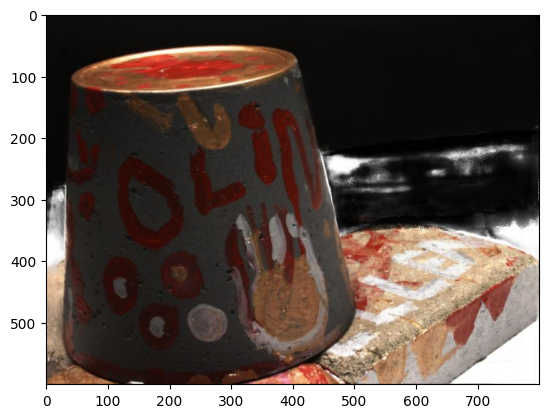

In [8]:
plt.imshow(img1)

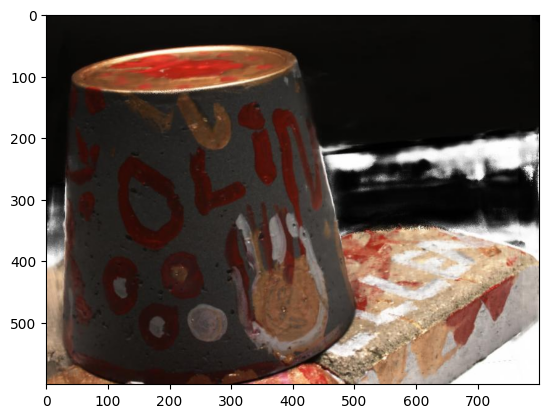

In [9]:
plt.imshow(img2)